# ITNPAI1 Computer Vision Assignment
### Student: 2938740

## Part I - Image Denoising

In [1]:
# Import libraries
import os
from time import perf_counter
import imageio
import numpy as np
import cv2
from matplotlib import pyplot as plt
#from skimage.transform import rescale, resize, 
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import denoise_wavelet
from skimage.metrics import peak_signal_noise_ratio
#from skimage.util import random_noise
#import skimage.io, skimage.color

In [2]:
def calc_stats(img_orig, img_noisy, img_denoise):
    
    # Calculate stats
    mse_n = np.mean((img_orig - img_noisy)**2).astype(np.uint8)
    mse_d = np.mean((img_orig - img_denoise)**2).astype(np.uint8)
    ssim_o = round(ssim(img_orig, img_orig, data_range=(img_orig.max()-img_orig.min()), multichannel=True, gaussian_weights=True, sigma=1.5, use_sampe_covariance=False), 2)
    ssim_n = round(ssim(img_noisy, img_orig, data_range=(img_noisy.max()-img_noisy.min()), multichannel=True, gaussian_weights=True, sigma=1.5, use_sampe_covariance=False), 2)
    ssim_d = round(ssim(img_denoise, img_orig, data_range=(img_denoise.max()-img_denoise.min()), multichannel=True, gaussian_weights=True, sigma=1.5, use_sampe_covariance=False), 2)

    return mse_n, mse_d, ssim_o, ssim_n, ssim_d


def denoise_mean_median(img_orig, img_noisy, target, file, ftype):

    # Box filter (mean blur) with 3x3 kernel
    if (ftype == 'mean'):
        img_denoise = cv2.blur(img_noisy,(3,3))
    elif (ftype == 'median'):
        img_denoise = cv2.medianBlur(img_noisy, 3)
    
    # Save output
    cv2.imwrite('images/'+target+'/denoised/'+ftype+'/'+file, cv2.cvtColor(img_denoise, cv2.COLOR_RGB2BGR))

    # Calculate stats
    mse_n, mse_d, ssim_o, ssim_n, ssim_d = calc_stats(img_orig, img_noisy, img_denoise)

    return mse_n, mse_d, ssim_o, ssim_n, ssim_d


def denoise_wavelets(img_orig, img_noisy, target, file):

    # Estimate sigma, the noise function
    img_noisy2 = skimage.img_as_float(img_noisy)

    # Denoise using Bayes denoising (tests found superior to visushrink)
    img_denoise = denoise_wavelet(img_noisy2, method='BayesShrink', mode='soft', wavelet_levels=5, wavelet='coif5', multichannel=True, convert2ycbcr=True, rescale_sigma=True)
    
    # Save output after re-scaling [0-255] from [0-1] and clipping value outside of expected range
    img_denoise = np.where(img_denoise < 0, 0, img_denoise) 
    img_denoise = np.where(img_denoise > 1, 1, img_denoise) 
    img_denoise *= 255
    imageio.imwrite('images/'+target+'/denoised/wavelet/'+file, img_denoise.astype('uint8'))

    # Calculate stats (clip to prevent values outside of expected range)
    mse_n, mse_d, ssim_o, ssim_n, ssim_d = calc_stats(img_orig, img_noisy, img_denoise)
    
    return mse_n, mse_d, ssim_o, ssim_n, ssim_d



In [3]:
# Define list of folders
root = r'images'
source = r'original'
targets = [dir for dir in os.listdir(root) if dir != source]

# Create list of files in source folder
originals = [file for file in os.listdir(os.path.join(root, source))]
num_originals = len(originals)

# Initialise result lists for mean squared error (before, after) and structural similarity (orig, noisy, denoise)
results_mean = [{'target':target, 'type':{'mse':[(None, None)]*num_originals, 'ssim':[(None, None, None)]*num_originals}} for target in targets]
results_median = [{'target':target, 'type':{'mse':[(None, None)]*num_originals, 'ssim':[(None, None, None)]*num_originals}} for target in targets]
results_wavelet = [{'target':target, 'type':{'mse':[(None, None)]*num_originals, 'ssim':[(None, None, None)]*num_originals}} for target in targets]
results_dncnn = [{'target':target, 'type':{'mse':[(None, None)]*num_originals, 'ssim':[(None, None, None)]*num_originals}} for target in targets]

# Start timer
tik = perf_counter()

# Loop through each source image so that it is loaded only once
for i, file in enumerate(originals):
    # Call out image being processed
    print(f"\033[1mProcessing {file} - file {i+1} of {num_originals}\n{41*'-'}\033[0m")

    # Import original
    img_orig = cv2.cvtColor(cv2.imread(os.path.join(root, source, file), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
     
    # Debug early stopper
    #if (file == '0002.png'):
     #   break
    
    # Loop target image in each noisy image collection
    for j, target in enumerate(targets):
        # Call out target folder for current iteration
        print(f"Denoising target image in folder: {target}")

        # Import noisy img
        img_noisy = cv2.cvtColor(cv2.imread(os.path.join(root, target, file), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

        # Call mean filter and store results in dictionary
        results = denoise_mean_median(img_orig, img_noisy, target, file, 'mean')
        results_mean[j]['type']['mse'][i], results_mean[j]['type']['ssim'][i] = results[0:2], results[2:5]
        
        # Call median filter and store results in dictionary
        results = denoise_mean_median(img_orig, img_noisy, target, file, 'median')
        results_median[j]['type']['mse'][i], results_median[j]['type']['ssim'][i] = results[0:2], results[2:5]
        
        # Call wavelet filter and store results in dictionary
        results = denoise_wavelets(img_orig, img_noisy, target, file)
        results_wavelet[j]['type']['mse'][i], results_wavelet[j]['type']['ssim'][i] = results[0:2], results[2:5]

        # Call DnCNN filter and store results in dictionary
        #results = denoise_CnCNN(img_orig, img_noisy, target, file)
        #results_dncnn[j]['type']['mse'][i], results_dict[j]['type']['ssim'][i] = results[0:2], results[2:5]

    print("\n")

# End timer
tok = perf_counter()
print(f"All images denoised in {round(tok-tik, 3)} seconds")
print(f"\033[1mAll images successfully denoised. Please see images/.../denoised/ folders for results\033[0m")

# Display summary
print("\n\n")

#print(results_mean)



Processing 0000.png - file 1 of 26
-----------------------------------------
Denoising target image in folder: noisy10


C:\Users\admin\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Denoising target image in folder: noisy25
Denoising target image in folder: noisy50


Processing 0001.png - file 2 of 26
-----------------------------------------
Denoising target image in folder: noisy10
Denoising target image in folder: noisy25
Denoising target image in folder: noisy50


Processing 0002.png - file 3 of 26
-----------------------------------------
Denoising target image in folder: noisy10
Denoising target image in folder: noisy25
Denoising target image in folder: noisy50


Processing 0003.png - file 4 of 26
-----------------------------------------
Denoising target image in folder: noisy10
Denoising target image in folder: noisy25
Denoising target image in folder: noisy50


Processing 0004.png - file 5 of 26
-----------------------------------------
Denoising target image in folder: noisy10
Denoising target image in folder: noisy25
Denoising target image in folder: noisy50


Processing 0005.png - file 6 of 26
-----------------------------------------
Denoising target 

In [72]:
# Display summary
print("(Mean results dictionary\n", results_mean)
print("\n\n")
print("(Median results dictionary\n", results_median)
print("\n\n")
print("(Wavelet results dictionary\n", results_wavelet)

(Mean results dictionary
 [{'target': 'noisy10', 'type': {'mse': [(60, 14), (60, 43), (59, 23), (59, 45), (60, 45), (58, 45), (56, 39), (59, 78), (59, 68), (52, 38), (58, 36), (60, 27), (54, 50), (57, 24), (60, 42), (60, 58), (60, 38), (60, 33), (59, 52), (60, 32), (60, 33), (60, 49), (60, 51), (60, 23), (58, 44), (58, 37)], 'ssim': [(1.0, 0.34, 0.77), (1.0, 0.77, 0.83), (1.0, 0.56, 0.84), (1.0, 0.74, 0.79), (1.0, 0.73, 0.78), (1.0, 0.72, 0.74), (1.0, 0.73, 0.87), (1.0, 0.92, 0.74), (1.0, 0.84, 0.66), (1.0, 0.68, 0.82), (1.0, 0.64, 0.78), (1.0, 0.66, 0.86), (1.0, 0.79, 0.78), (1.0, 0.58, 0.85), (1.0, 0.76, 0.83), (1.0, 0.8, 0.72), (1.0, 0.71, 0.82), (1.0, 0.66, 0.82), (1.0, 0.78, 0.78), (1.0, 0.7, 0.86), (1.0, 0.61, 0.8), (1.0, 0.75, 0.76), (1.0, 0.82, 0.85), (1.0, 0.54, 0.84), (1.0, 0.7, 0.73), (1.0, 0.63, 0.78)]}}, {'target': 'noisy25', 'type': {'mse': [(93, 52), (93, 64), (92, 55), (92, 65), (93, 65), (90, 67), (87, 67), (92, 84), (91, 78), (80, 71), (90, 64), (93, 57), (84, 74), (8

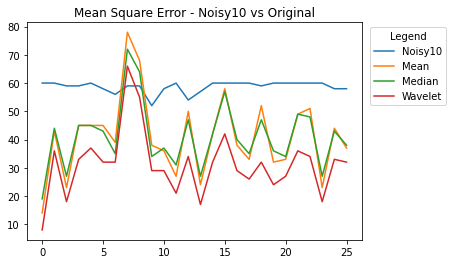

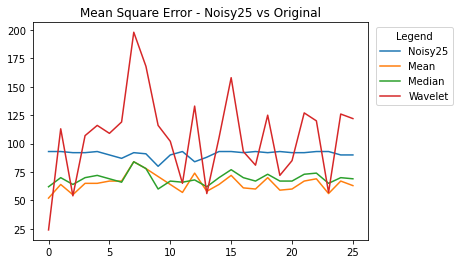

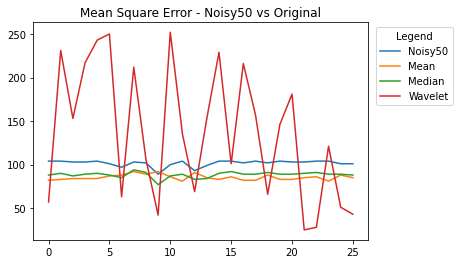

In [68]:
# Create output graphs for MSE statistics
idx = list(range(0, 26))
titles = ['Noisy10', 'Noisy25', 'Noisy50']
for i in range(3):
    # Create plot for MSE error statistic - noisy10
    a0 = list(zip(*results_mean[i]['type']['mse']))[0]
    a1 = list(zip(*results_mean[i]['type']['mse']))[1]
    a2 = list(zip(*results_median[i]['type']['mse']))[1]
    a3 = list(zip(*results_wavelet[i]['type']['mse']))[1]
    plt.plot(idx, a0), plt.plot(idx, a1), plt.plot(idx, a2), plt.plot(idx, a3)
    plt.title(f'Mean Square Error - {titles[i]} vs Original')
    plt.legend([titles[i], 'Mean', 'Median', 'Wavelet'], title='Legend', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

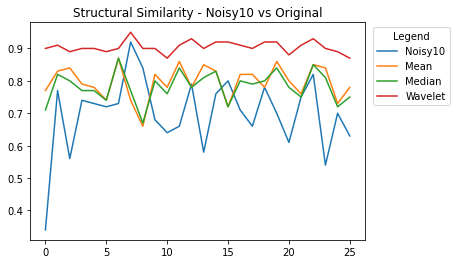

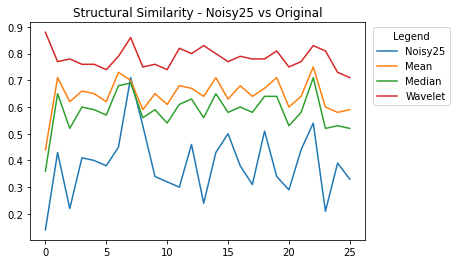

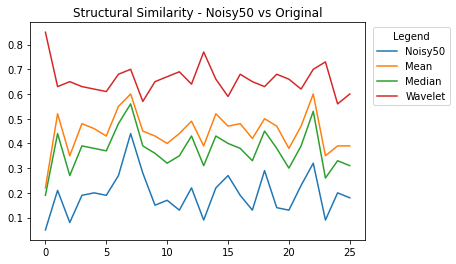

In [70]:
# Create index for x-axis
idx = list(range(0, 26))
titles = ['Noisy10', 'Noisy25', 'Noisy50']
for i in range(3):
    # Create plot for MSE error statistic - noisy10
    a0 = list(zip(*results_mean[i]['type']['ssim']))[1]
    a1 = list(zip(*results_mean[i]['type']['ssim']))[2]
    a2 = list(zip(*results_median[i]['type']['ssim']))[2]
    a3 = list(zip(*results_wavelet[i]['type']['ssim']))[2]
    plt.plot(idx, a0), plt.plot(idx, a1), plt.plot(idx, a2), plt.plot(idx, a3)
    plt.title(f'Structural Similarity - {titles[i]} vs Original')
    plt.legend([titles[i], 'Mean', 'Median', 'Wavelet'], title='Legend', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

## Spare Code & Notes

There is always a trade off between removing noise and preserving the edges of an image. In order to remove the speckle noise in an image a blurring filter needs to be applied which in turn blurs the edges of the image. If you want to retain the edges of an image the only noise that you can remove is the salt-and-pepper noise.<br><br>
You can see the median filter leaves a nice, crisp divide between the red and white regions, whereas the Gaussian is a little more fuzzy. The difference may not be as drastic as the example of the brain MRI with salt and pepper noise, but optimizing edge detection is an important concept for image processing and computer vision, even if the optimizations seem marginal. That’s not to say, however, that Median filtering is the optimal solution for all edge detection endeavors. In fact, in an upcoming article I’ll discuss the Canny edge detector, which is a popular, and quite powerful multi-stage algorithm that actually doesn’t use Median filtering.

In [ ]:
# Import one image
img1, img2 = 'images/original/0011.png', 'images/noisy25/0011.png'
img_orig = cv2.cvtColor(cv2.imread(img1, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
img_noisy = cv2.cvtColor(cv2.imread(img2, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

kernel = np.ones((3, 3), np.float32)/9
img_denoise = cv2.filter2D(img_noisy, -1, kernel)
img_denoise2 = cv2.blur(img_noisy,(3,3))


#img_denoise = cv2.bilateralFilter(img_noisy,5,75,75)
#img_denoise = cv2.bilateralFilter(img_denoise,5,75,75)
#img_denoise = cv2.bilateralFilter(img_denoise,5,75,75)

#img_denoise = cv2.blur(img_noisy,(3,3))
#img_denoise = cv2.blur(img_denoise,(3,3))
#img_denoise = cv2.medianBlur(img_noisy, 3)
#img_denoise = cv2.medianBlur(img_denoise, 3)

# Plotting of source and destination image
#plt.imshow(img_orig), plt.xticks([]), plt.yticks([]), plt.show()
plt.imshow(img_noisy), plt.xticks([]), plt.yticks([]), plt.show()
plt.imshow(img_denoise), plt.xticks([]), plt.yticks([]), plt.show()
plt.imshow(img_denoise2), plt.xticks([]), plt.yticks([]), plt.show()

# Calculate mean square error
mse_noise = np.mean((img_orig - img_noisy)**2).astype(np.uint8)
mse_denoise = np.mean((img_orig - img_denoise)**2).astype(np.uint8)
mse_denoise2 = np.mean((img_orig - img_denoise2)**2).astype(np.uint8)

# Calculate structural difference
print(mse_noise, mse_denoise, mse_denoise2)

In [ ]:
img_orig = cv2.imread('images/original/0006.png')
img_noisy = cv2.imread('images/noisy25/0006.png')
img_orig = cv2.cvtColor(cv2.imread(img1, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
img_noisy = cv2.cvtColor(cv2.imread(img2, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)

img_denoise = cv2.Laplacian(img_noisy,cv2.CV_64F)

# Plot side by side
plt.figure(figsize=(11,6))
plt.subplot(131), plt.imshow(img_orig, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(img_denoise, cmap='gray'),plt.title('Laplacian')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_noisy + img_denoise, cmap='gray'),plt.title('Resulting image')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
#img_denoise = cv2.fastNlMeansDenoisingColored(img_noisy,None,25,25,9,3)


Non-local means from scikit-image<br>
The non-local means algorithm is well suited for denoising images with specific textures. The principle of the algorithm is to average the value of a given pixel with values of other pixels in a limited neighbourhood, provided that the patches centered on the other pixels are similar enough to the patch centered on the pixel of interest.4

textures have a big impact, more finer details got lost, flat or landscapes from a distance look better
median better for salt and pepper noise

bilateral filters good for retaining edges

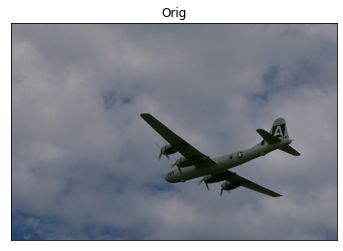

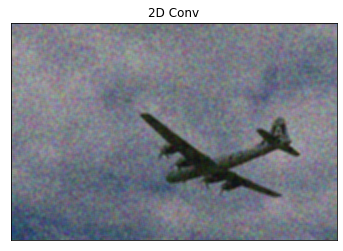

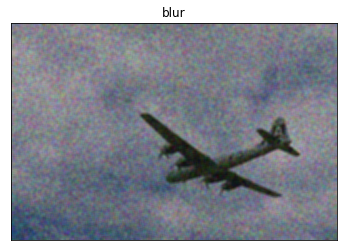

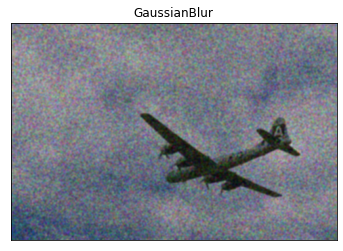

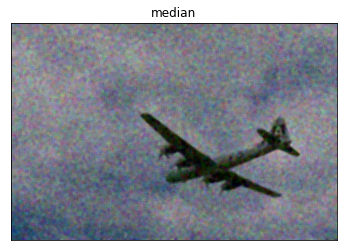

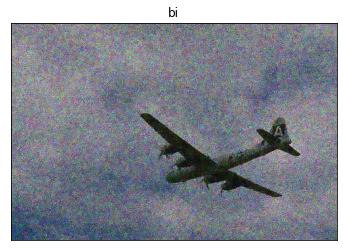

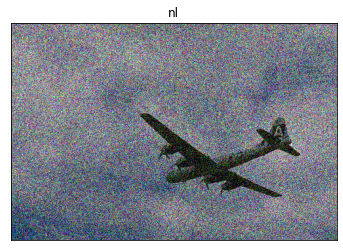

In [74]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

orig = cv2.cvtColor(cv2.imread('images/original/0000.png'), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(cv2.imread('images/noisy50/0000.png'), cv2.COLOR_BGR2RGB)

k = 5
kernel = 1*np.ones((k, k), np.float32)/(k**2)
dst = cv2.filter2D(img, -1, kernel)
blur = cv2.blur(img, (k, k))
gaus = cv2.GaussianBlur(img, (k, k), 0)
median = cv2.medianBlur(img, k)
bilateral = cv2.bilateralFilter(img, 9, 75, 75)
nl = cv2.fastNlMeansDenoisingColored(img,None,9,9,7,21)

titles = ['Orig', '2D Conv', 'blur', 'GaussianBlur', 'median', 'bi', 'nl']
images = [orig, dst, blur, gaus, median, bilateral, nl]
for i in range(len(images)):
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
    plt.show()



In [ ]:
# https://www.youtube.com/watch?v=eNwbSR3rNX4
# Image denoising using wavelet transform in python
# Dr. Ajay Kumar Verma

In [ ]:

img = skimage.io.imread('images/original/0025.png')
img = skimage.img_as_float(img)

imgn = skimage.io.imread('images/noisy50/0025.png')
imgn = skimage.img_as_float(imgn)
sigma_est = estimate_sigma(imgn, multichannel=True, average_sigmas=True)

# Denoise using Bayes
img_bayes = denoise_wavelet(imgn, method='BayesShrink', mode='soft', wavelet_levels=5, wavelet='coif5', multichannel=True, convert2ycbcr=True, rescale_sigma=True)
    
# Findng PSNR
psnr_noisy = peak_signal_noise_ratio(img, imgn)
psnr_bayes = peak_signal_noise_ratio(img, img_bayes)

# Plot results
#plt.figure(figsize=(12, 8))

#plt.subplot(2,2,1)
#plt.imshow(img, cmap=plt.cm.gray)
#plt.title('Original Image', fontsize=30)

#plt.subplot(2,2,2)
#plt.imshow(imgn, cmap=plt.cm.gray)
#plt.title('Noisy Image', fontsize=30)

#plt.subplot(2,2,3)
plt.imshow(img_bayes, cmap=plt.cm.gray)
plt.title('Bayes', fontsize=30)

plt.axis('off')
plt.show()

#plt.imsave('test.png', img_bayes)
imageio.imwrite('test.png', img_bayes)

# Printing PSNR
print('PSNR [Original vs. Noisy Image]:', psnr_noisy)
print('PSNR [Original vs. Bayes]:', psnr_bayes)




In [ ]:
# Bayes seems to produce less artifacts when denoising data

## SSIM Calc

In [ ]:

mse = mean_squared_error(img, imgn)
mse_b = mean_squared_error(img, img_bayes)
mse_v = mean_squared_error(img, img_visu)
ssim_o = ssim(img, img, data_range=(img.max()-img.min()), multichannel=True, gaussian_weights=True, sigma=1.5, use_sampe_covariance=False)
ssim_n = ssim(img, imgn, data_range=(imgn.max()-imgn.min()), multichannel=True, gaussian_weights=True, sigma=1.5, use_sampe_covariance=False)
ssim_b = ssim(img, img_bayes, data_range=(img_bayes.max()-img_bayes.min()), multichannel=True, gaussian_weights=True, sigma=1.5, use_sampe_covariance=False)
ssim_v = ssim(img, img_visu, data_range=(img_visu.max()-img_visu.min()), multichannel=True, gaussian_weights=True, sigma=1.5, use_sampe_covariance=False)

print(f"mse noisy: {mse}")
print(f"mse visu: {mse_v}")
print(f"mse bayes: {mse_b}")
print("-----------------------------")
print(f"ssim: {ssim_o}")
print(f"ssim: {ssim_n}")
print(f"ssim visu: {ssim_v}")
print(f"ssim bayes: {ssim_b}")